In [245]:
import matplotlib.pyplot as plt
import bagpy
import pandas as pd
import numpy as np

In [246]:
bag = bagpy.bagreader('/home/ziad/ever_comp/src/autonomx_state_estimator/rosbags/kf_ms_straight_2024-04-25-21-41-18.bag')
bag.topic_table

[INFO]  Data folder /home/ziad/ever_comp/src/autonomx_state_estimator/rosbags/kf_ms_straight_2024-04-25-21-41-18 already exists. Not creating.


,Topics,Types,Message Count,Frequency
0,/Imu,sensor_msgs/Imu,1558,100.062123
1,/SteeringAngle,std_msgs/Float64,1628,100.000095
2,/clock,rosgraph_msgs/Clock,1558,100.109889
3,/cmd_vel,std_msgs/Float64,1628,100.000095
4,/current_heading,std_msgs/Float64,1523,99.990560
5,/current_linear_velocity,geometry_msgs/Vector3,1523,99.997711
6,/current_position,geometry_msgs/Vector3,1523,99.992943
7,/ground_truth,nav_msgs/Odometry,1523,99.940526
8,/noisy_readings,nav_msgs/Odometry,1523,99.900060
9,/odom,nav_msgs/Odometry,1559,100.053768


In [247]:
# extract topics of interest
ground_truth_topic_data = pd.read_csv(bag.message_by_topic('/ground_truth'))
noisy_data_topic_data = pd.read_csv(bag.message_by_topic('/noisy_readings'))
heading_estimations_topic_data = pd.read_csv(bag.message_by_topic('/current_heading'))
velocity_estimations_topic_data = pd.read_csv(bag.message_by_topic('/current_linear_velocity'))
position_estimation_topic_data = pd.read_csv(bag.message_by_topic('/current_position'))

# filtered_heading_topic_data = pd.read_csv(bag.message_by_topic('/filtered_heading'))

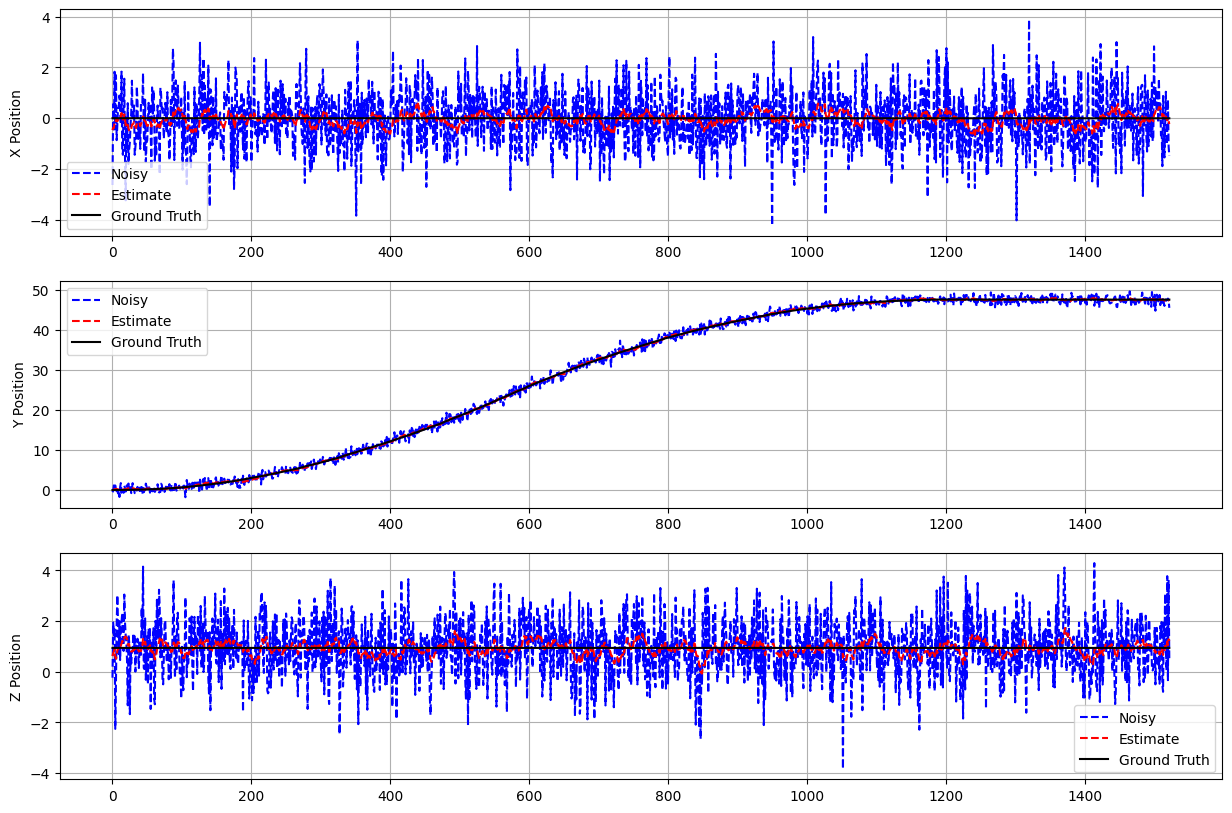

In [248]:
'''
    Plotting Ground Truth Velocity Compared to Estimated Velocities
'''

# extract the data i need as pd.sereis and store them in a list
ground_truth_position = [ground_truth_topic_data['pose.pose.position.x'], ground_truth_topic_data['pose.pose.position.y'], ground_truth_topic_data['pose.pose.position.z']]
noisy_position = [noisy_data_topic_data['pose.pose.position.x'], noisy_data_topic_data['pose.pose.position.y'], noisy_data_topic_data['pose.pose.position.z']]
estimated_position = [position_estimation_topic_data['x'], position_estimation_topic_data['y'], position_estimation_topic_data['z']]

fig1, axes1 = plt.subplots(3, 1, figsize=(15, 10))  # Create 3 rows, 1 column subplot
for i, ax in enumerate(axes1):
    ax.plot(range(len(noisy_position[i])), noisy_position[i], label='Noisy', color='blue', linestyle = '--')
    ax.plot(range(len(estimated_position[i])), estimated_position[i], label='Estimate', color='red', linestyle = '--')
    ax.plot(range(len(ground_truth_position[i])), ground_truth_position[i], label='Ground Truth', color='black')
    axis = 'X' if i==0 else ('Y' if i==1 else 'Z')
    ax.set_ylabel(f'{axis} Position')
    ax.legend()
    ax.grid()

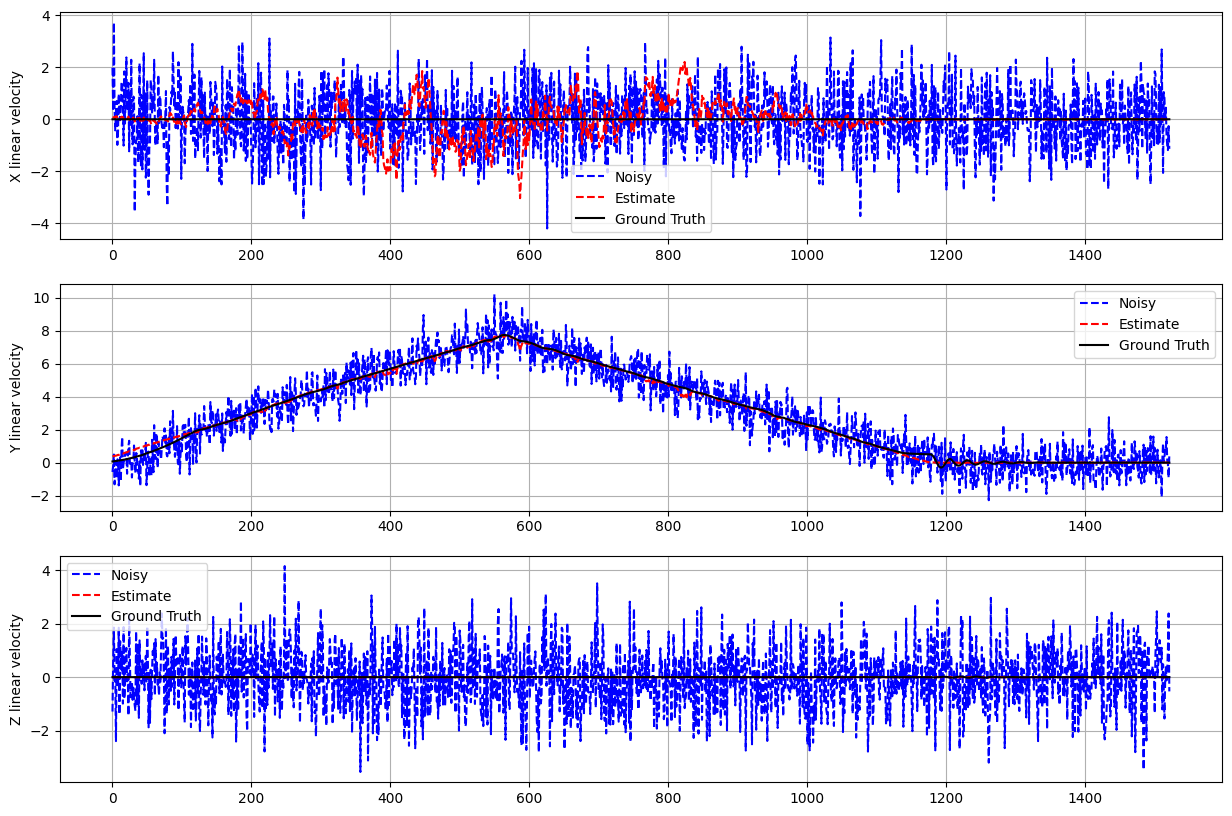

In [249]:
'''
    Plotting Ground Truth Velocity Compared to Estimated Velocities
'''

# extract the data i need as pd.sereis and store them in a list
ground_truth_velocity = [ground_truth_topic_data['twist.twist.linear.x'], ground_truth_topic_data['twist.twist.linear.y'], ground_truth_topic_data['twist.twist.linear.z']]
noisy_velocity = [noisy_data_topic_data['twist.twist.linear.x'], noisy_data_topic_data['twist.twist.linear.y'], noisy_data_topic_data['twist.twist.linear.z']]
estimated_velocity = [velocity_estimations_topic_data['x'], velocity_estimations_topic_data['y'], velocity_estimations_topic_data['z']]

fig1, axes1 = plt.subplots(3, 1, figsize=(15, 10))  # Create 3 rows, 1 column subplot
for i, ax in enumerate(axes1):
    ax.plot(range(len(noisy_velocity[i])), noisy_velocity[i], label='Noisy', color='blue', linestyle = '--')
    ax.plot(range(len(estimated_velocity[i])), estimated_velocity[i], label='Estimate', color='red', linestyle = '--')
    ax.plot(range(len(ground_truth_velocity[i])), ground_truth_velocity[i], label='Ground Truth', color='black')
    axis = 'X' if i==0 else ('Y' if i==1 else 'Z')
    ax.set_ylabel(f'{axis} linear velocity')
    ax.legend()
    ax.grid()

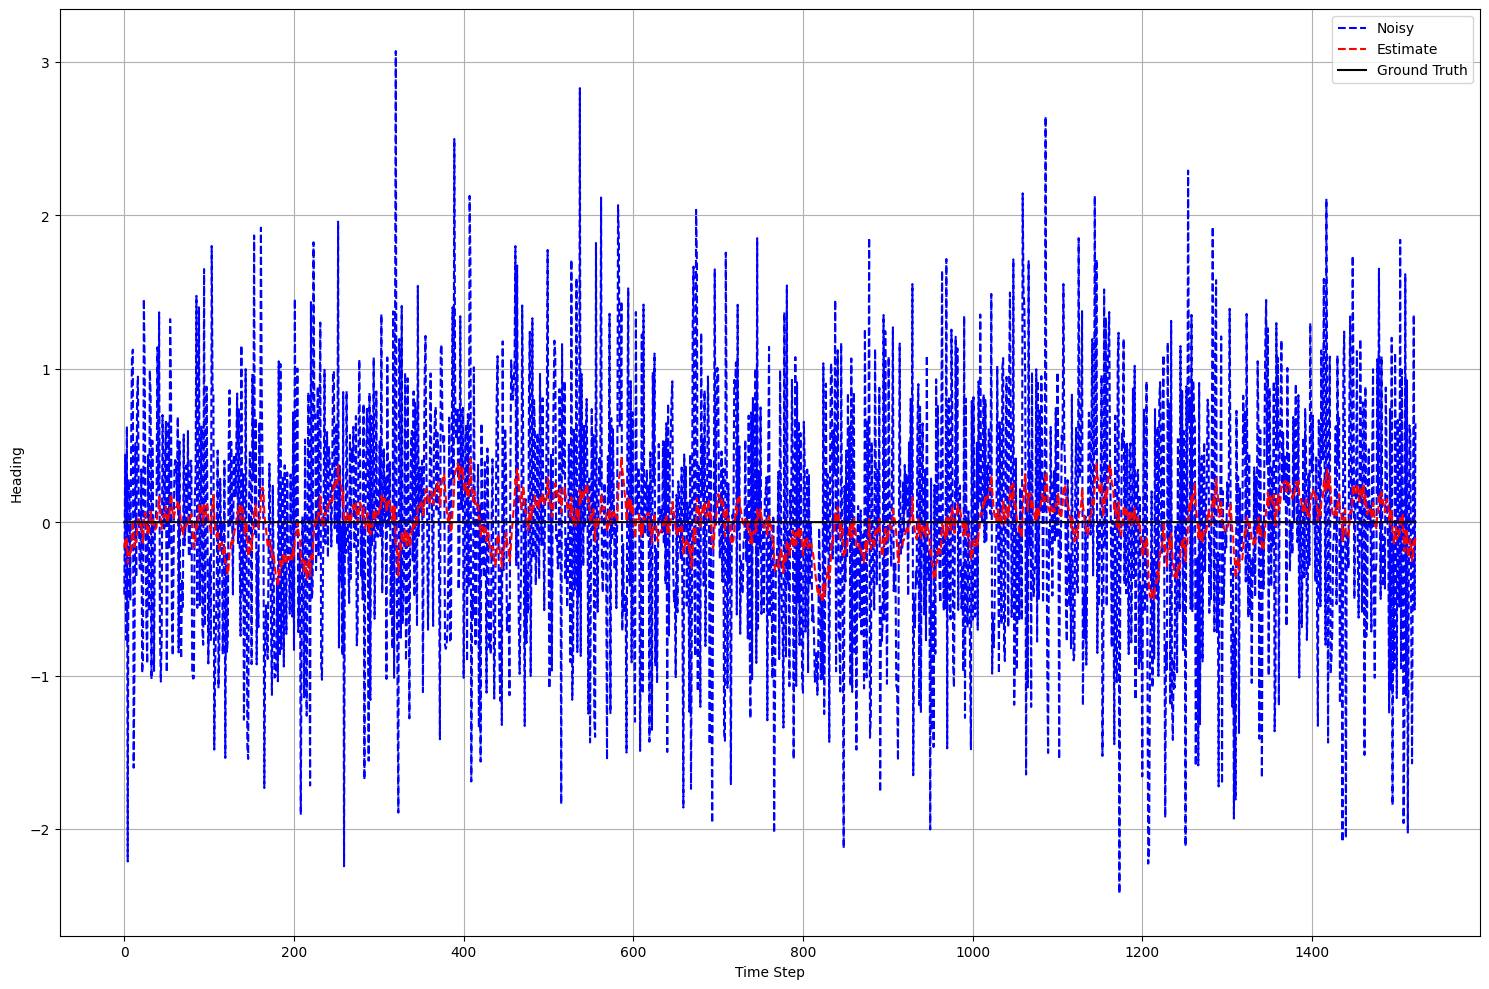

1523
1523


In [250]:
'''
    Plotting the ground truth heading compared to the estimated heading
'''
from tf.transformations import euler_from_quaternion

ground_truth_orientation = [ground_truth_topic_data['pose.pose.orientation.x'], ground_truth_topic_data['pose.pose.orientation.y'],ground_truth_topic_data['pose.pose.orientation.z'], ground_truth_topic_data['pose.pose.orientation.w']]
noisy_orientation = [noisy_data_topic_data['pose.pose.orientation.x'], noisy_data_topic_data['pose.pose.orientation.y'],noisy_data_topic_data['pose.pose.orientation.z'], noisy_data_topic_data['pose.pose.orientation.w']]
estimated_heading = heading_estimations_topic_data['data']

# filtered_heading = filtered_heading_topic_data['data']

ground_truth_heading = np.zeros_like(ground_truth_orientation[1].values)
noisy_heading = np.zeros_like(ground_truth_orientation[1].values)

# Converting the orientation from quaternion to euler and extracting the yaw

for i in range(len(ground_truth_orientation[1])):
    ground_truth_heading[i] = euler_from_quaternion((ground_truth_orientation[0][i], ground_truth_orientation[1][i], ground_truth_orientation[2][i], ground_truth_orientation[3][i]))[2]

for i in range(len(noisy_orientation[1])):
    noisy_heading[i] = euler_from_quaternion((noisy_orientation[0][i], noisy_orientation[1][i], noisy_orientation[2][i], noisy_orientation[3][i]))[2]

fig3, axes3 = plt.subplots(1, 1, figsize=(15, 10))
axes3.plot(range(len(noisy_heading)), noisy_heading, label='Noisy', color='blue', linestyle='--')
axes3.plot(range(len(estimated_heading)), estimated_heading, label='Estimate', color='red', linestyle='--')
# axes3.plot(range(len(filtered_heading)), filtered_heading, label='Filtered', color='orange', linestyle='--')
axes3.plot(range(len(ground_truth_heading)), ground_truth_heading, label='Ground Truth', color='black')
axes3.set_ylabel('Heading')
axes3.legend()
axes3.grid()
plt.xlabel("Time Step")
plt.tight_layout()  # Adjust spacing between subplots (optional)
plt.show()

print(len(noisy_heading))
print(len(ground_truth_heading))

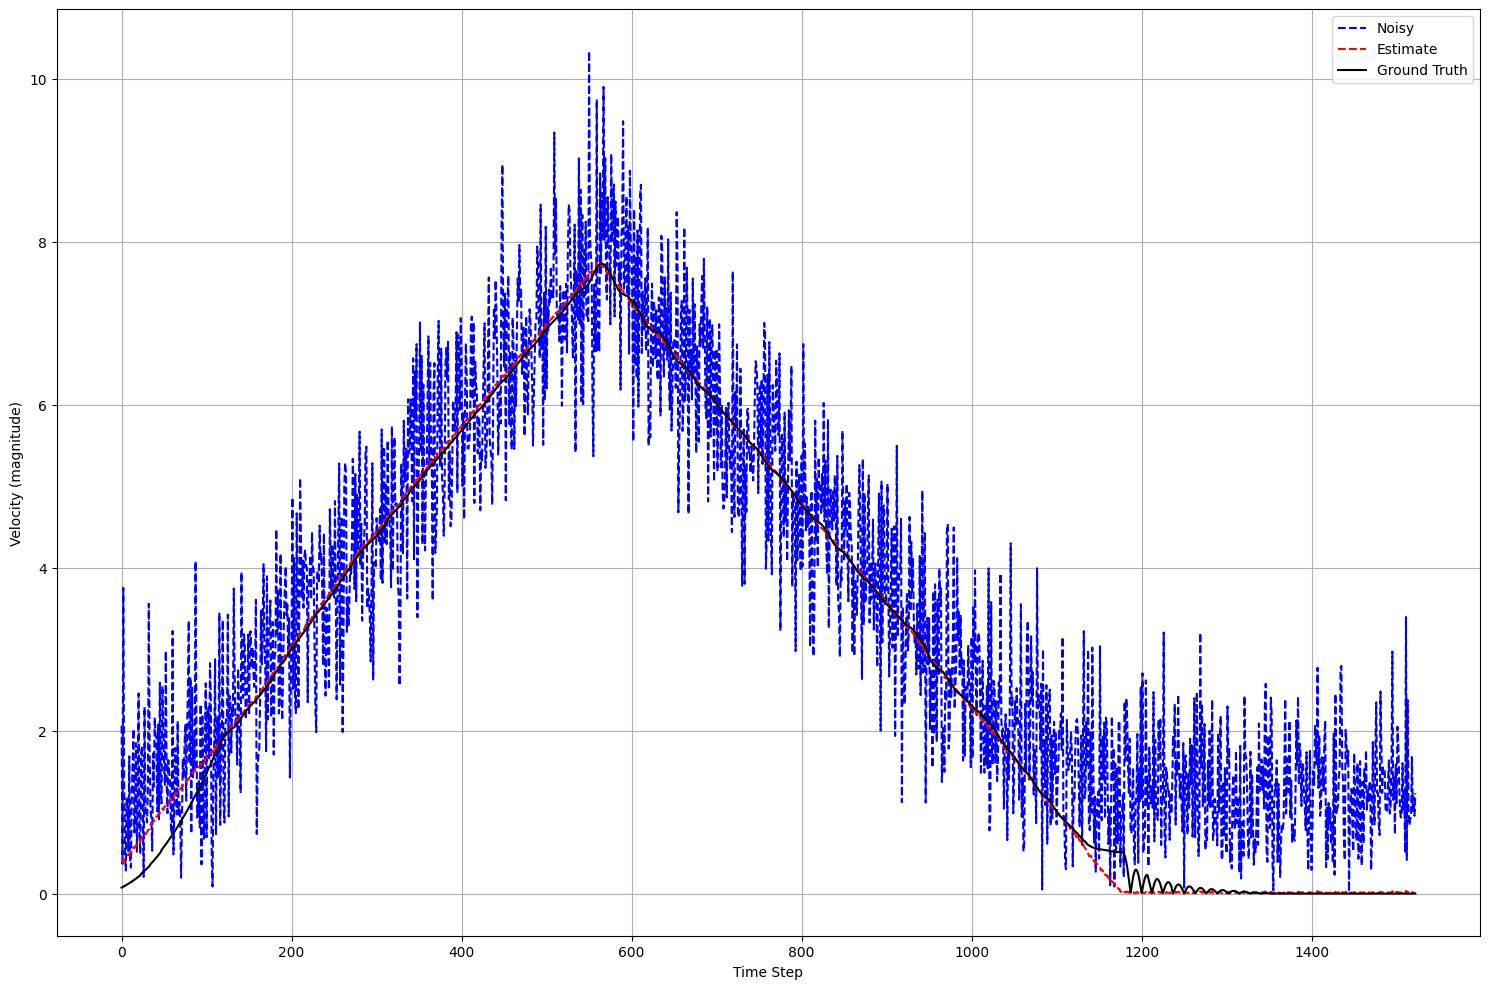

In [251]:
'''Checking Velocity Magnitudes'''
velocity_estimated = np.hypot(estimated_velocity[0].values, estimated_velocity[1].values)
velocity_actual = np.hypot(ground_truth_velocity[0].values, ground_truth_velocity[1].values)
velocity_noisy = np.hypot(noisy_velocity[0].values, noisy_velocity[1].values)

fig3, axes4 = plt.subplots(1, 1, figsize=(15, 10))
axes4.plot(range(len(velocity_noisy)),velocity_noisy, label='Noisy', color='blue', linestyle='--')
axes4.plot(range(len(velocity_estimated)),velocity_estimated, label='Estimate', color='red', linestyle='--')
axes4.plot(range(len(velocity_actual)),velocity_actual, label='Ground Truth', color='black')
axes4.set_ylabel('Velocity (magnitude)')
axes4.legend()
axes4.grid()
plt.xlabel("Time Step")
plt.tight_layout()  # Adjust spacing between subplots (optional)
plt.show()


In [252]:
'''Performing some error analytics'''

max_X_position_error = np.max(ground_truth_position[0] - estimated_position[0])
max_Y_position_error = np.max(ground_truth_position[1] - estimated_position[1])
max_Z_position_error = np.max(ground_truth_position[2] - estimated_position[2])

MSE_X_position = np.mean((ground_truth_position[0] - estimated_position[0])**2)
MSE_Y_position = np.mean((ground_truth_position[1] - estimated_position[1])**2)
MSE_Z_position = np.mean((ground_truth_position[2] - estimated_position[2])**2)

max_X_velocity_error = np.max(ground_truth_velocity[0] - estimated_velocity[0])
max_Y_velocity_error = np.max(ground_truth_velocity[1] - estimated_velocity[1])
max_Z_velocity_error = np.max(ground_truth_velocity[2] - estimated_velocity[2])

MSE_X_velocity = np.mean((ground_truth_velocity[0] - estimated_velocity[0])**2)
MSE_Y_velocity = np.mean((ground_truth_velocity[1] - estimated_velocity[1])**2)
MSE_Z_velocity = np.mean((ground_truth_velocity[2] - estimated_velocity[2])**2)

max_heading_error = np.max(ground_truth_heading - estimated_heading[:len(ground_truth_heading)])
MSE_heading = np.mean((ground_truth_heading - estimated_heading[:len(ground_truth_heading)])**2)


print("max_X_position_error: ", max_X_position_error)
print("MSE_X_position: ", MSE_X_position)
print("")
print("max_Y_position_error: ", max_Y_position_error)
print("MSE_Y_position: ", MSE_Y_position)
print("")
print("max_Z_position_error: ", max_Z_position_error)
print("MSE_Z_position: ", MSE_Z_position)
print("")
print("max_X_velocity_error: ", max_X_velocity_error)
print("MSE_X_velocity: ", MSE_X_velocity)
print("")
print("max_Y_velocity_error: ", max_Y_velocity_error)
print("MSE_Y_velocity: ", MSE_X_velocity)
print("")
print("max_Z_velocity_error: ", max_Z_velocity_error)
print("MSE_Z_velocity: ", MSE_X_velocity)
print("")
print("max_heading_error: ", max_heading_error)
print("MSE_heading: ", MSE_heading)


max_X_position_error:  0.6497091713916312
MSE_X_position:  0.05559509731135653

max_Y_position_error:  0.7002975030363547
MSE_Y_position:  0.03712586717781074

max_Z_position_error:  1.013952968592229
MSE_Z_position:  0.05707528312701992

max_X_velocity_error:  3.0347854439182362
MSE_X_velocity:  0.3628073197454984

max_Y_velocity_error:  0.6239886611917584
MSE_Y_velocity:  0.3628073197454984

max_Z_velocity_error:  0.0324116223614883
MSE_Z_velocity:  0.3628073197454984

max_heading_error:  0.5224812407162007
MSE_heading:  0.02486206707776817
